### This notebook uses a current PR of gcr-catalogs, make sure you clone the PR and add it to `sys.path`
```
git clone -b coadd_reader git@github.com:djperrefort/gcr-catalogs.git
```

This notebook also requires `FoFCatalogMatching`: https://github.com/yymao/FoFCatalogMatching

In [1]:
import sys
sys.path.insert(0, '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages')
sys.path.insert(0, '/global/homes/b/bhairav/gcr-catalogs')
from collections import defaultdict
import numpy as np
from astropy.coordinates import SkyCoord
import FoFCatalogMatching
from GCR import GCRQuery
import GCRCatalogs
from scipy.optimize import curve_fit
import operator
from matplotlib.colors import LogNorm

In [2]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
GCRCatalogs.available_catalogs
coaddCat = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')
#refCat = GCRCatalogs.load_catalog('dc2_reference_run1.1p')
refCat = GCRCatalogs.load_catalog('dc2_truth_run1.1', {'md5': None})
print (len(coaddCat['ra']), len(refCat['ra']))

6892380 10590160


In [4]:
refCat.add_quantity_modifier('i_mag_cmodel', 
                              (lambda x: -2.5 * np.log10(x) + 27.0, 'i_modelfit_CModel_flux'), 
                              overwrite=True)
refCat.add_quantity_modifier('i_SN_cmodel', 
                              (np.divide, 'i_modelfit_CModel_flux', 'i_modelfit_CModel_fluxSigma'), 
                              overwrite=True)
refCat.add_quantity_modifier('HSM_res', 
                              'ext_shapeHSM_HsmShapeRegauss_resolution', 
                              overwrite=True)
refCat.add_quantity_modifier('HSM_ell', 
                              (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                              overwrite=True)
refCat.add_quantity_modifier('psf_size', 
                              (lambda xx, yy, xy: 0.168*2.355*(xx*yy - xy*xy)**0.25, 'i_base_SdssShape_psf_xx', 'i_base_SdssShape_psf_yy', 'i_base_SdssShape_psf_xy'),
                              overwrite=True)

coaddCat.add_quantity_modifier('i_mag_cmodel', 
                              (lambda x: -2.5 * np.log10(x) + 27.0, 'i_modelfit_CModel_flux'), 
                              overwrite=True)
coaddCat.add_quantity_modifier('i_SN_cmodel', 
                              (np.divide, 'i_modelfit_CModel_flux', 'i_modelfit_CModel_fluxSigma'), 
                              overwrite=True)
coaddCat.add_quantity_modifier('HSM_res', 
                              'ext_shapeHSM_HsmShapeRegauss_resolution', 
                              overwrite=True)
coaddCat.add_quantity_modifier('HSM_ell', 
                              (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                              overwrite=True)
coaddCat.add_quantity_modifier('psf_size', 
                              (lambda xx, yy, xy: 0.168*2.355*(xx*yy - xy*xy)**0.25, 'i_base_SdssShape_psf_xx', 'i_base_SdssShape_psf_yy', 'i_base_SdssShape_psf_xy'),
                              overwrite=True)

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCR.py:436: UserWarning: Native quantity `i_modelfit_CModel_flux` does not exist (required by `i_mag_cmodel`)
  warnings.warn(msg)
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCR.py:436: UserWarning: Native quantity `i_modelfit_CModel_flux` does not exist (required by `i_SN_cmodel`)
  warnings.warn(msg)
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCR.py:436: UserWarning: Native quantity `ext_shapeHSM_HsmShapeRegauss_resolution` does not exist (required by `HSM_res`)
  warnings.warn(msg)
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCR.py:436: UserWarning: Native quantity `ext_shapeHSM_HsmShapeRegauss_e1` does not exist (required by `HSM_ell`)
  warnings.warn(msg)
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCR.py:436: UserWarning: Native quantity `i_base_Sd

In [5]:
#for data in coaddCat.get_quantities(['ra', 'dec'], return_iterator=True):
#    plt.scatter(data['ra'], data['dec'], s=1, rasterized=True);

#plt.xlabel('RA');
#plt.ylabel('Dec');

In [6]:
# do matching on a small area
ra_min, ra_max = 55.5, 56.0
dec_min, dec_max = -29.0, -28.5

coord_filter = GCRQuery(
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
)

In [7]:
mag_cutIn = GCRQuery(
    (np.isfinite, 'lsst_u'),
    'lsst_u < 45',
#    (np.isfinite, 'i_magLSST'),
#    'i_magLSST < 24.5',
)
mag_cutOut = GCRQuery(
    (np.isfinite, 'mag_i_lsst'),
    'mag_i_lsst < 24.5'
)

In [8]:
#GCRQuery((np.isnan, 'i_modelfit_CModel_flux')), # (from this and below) remove nan entries
#GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
#GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
#GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
#GCRQuery('detect_isPrimary'), # (from this and below) basic flag cuts 
#GCRQuery('deblend_skipped'),
#GCRQuery('base_PixelFlags_flag_edge'),
#GCRQuery('base_PixelFlags_flag_interpolatedCenter'),
#GCRQuery('base_PixelFlags_flag_saturatedCenter'),
#GCRQuery('base_PixelFlags_flag_crCenter'),
#GCRQuery('base_PixelFlags_flag_bad'),
#GCRQuery('base_PixelFlags_flag_suspectCenter'),
#GCRQuery('base_PixelFlags_flag_clipped'),
#GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag'),
#GCRQuery('i_SN_cmodel >= 10'), # (from this and below) cut on object properties
#GCRQuery('HSM_res >= 0.3'),
#GCRQuery('HSM_ell < 2.0'),
#GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
#GCRQuery('i_mag_cmodel < 24.5'), # FIXME: Doesnt have exinction correction
#GCRQuery('base_Blendedness_abs_flux < 10**(-0.375)'),
lensing_cuts = [
    GCRQuery(
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max)),
    #GCRQuery('mag_i < 24.5')
]

In [9]:
coordinatesCoaddCat = coaddCat.get_quantities(['ra', 'dec',
                                               'i_modelfit_CModel_flux',
                                               'ext_shapeHSM_HsmShapeRegauss_resolution',
                                               'ext_shapeHSM_HsmShapeRegauss_e1',
                                               'ext_shapeHSM_HsmShapeRegauss_e2',
                                               'detect_isPrimary',
                                               'deblend_skipped',
                                               'base_PixelFlags_flag_edge',
                                               'base_PixelFlags_flag_interpolatedCenter',
                                               'base_PixelFlags_flag_saturatedCenter',
                                               'base_PixelFlags_flag_crCenter',
                                               'base_PixelFlags_flag_bad',
                                               'base_PixelFlags_flag_suspectCenter',
                                               'base_PixelFlags_flag_clipped',
                                               'ext_shapeHSM_HsmShapeRegauss_flag',
                                               'i_SN_cmodel',
                                               'HSM_res',
                                               'HSM_ell',
                                               'ext_shapeHSM_HsmShapeRegauss_sigma',
                                               'i_mag_cmodel',
                                               'base_Blendedness_abs_flux',
                                               'mag_u',
                                               'mag_g',
                                               'mag_r',
                                               'mag_i',
                                               'mag_z',
                                               'mag_y'                                               
                                              ])#, filters=lensing_cuts)

coordinatesRefCat = refCat.get_quantities(['ra', 'dec',
                                           'mag_true_u',
                                           'mag_true_g',
                                           'mag_true_r',
                                           'mag_true_i',
                                           'mag_true_z',
                                           'mag_true_y'])#, filters=[coord_filter])

/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in log10
/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


In [10]:
results = FoFCatalogMatching.match(
    catalog_dict=dict(ref=coordinatesRefCat, coadd=coordinatesCoaddCat),
    linking_lengths=1.0,
    catalog_len_getter=lambda x: len(x['ra']))

In [11]:
ref_mask = results['catalog_key'] == 'ref'
coadd_mask = ~ref_mask
n_groups = results['group_id'].max() + 1
n_ref = np.bincount(results['group_id'][ref_mask], minlength=n_groups)
n_coadd = np.bincount(results['group_id'][coadd_mask], minlength=n_groups)
n_max = max(n_ref.max(), n_coadd.max()) + 1
hist_2d = np.bincount(n_coadd * n_max + n_ref, minlength=n_max*n_max).reshape(n_max, n_max)

"""n_max = 5
hist2d = np.zeros((n_max, n_max))
ref_idx = defaultdict(list)
coadd_idx = defaultdict(list)

for group in results.groups:
    ref_mask = group['catalog_key'] == 'ref'
    coadd_mask = group['catalog_key'] == 'coadd'
    
    n_ref = np.count_nonzero(ref_mask)
    n_coadd = np.count_nonzero(coadd_mask)
    if n_ref < n_max and n_coadd < n_max:
        hist2d[n_ref, n_coadd] += 1
    
    key = (n_ref, n_coadd)
    ref_idx[key].append(group['row_index'][ref_mask].data)
    coadd_idx[key].append(group['row_index'][coadd_mask].data)

for key in ref_idx:
    ref_idx[key] = np.concatenate(ref_idx[key])
    coadd_idx[key] = np.concatenate(coadd_idx[key])"""

"n_max = 5\nhist2d = np.zeros((n_max, n_max))\nref_idx = defaultdict(list)\ncoadd_idx = defaultdict(list)\n\nfor group in results.groups:\n    ref_mask = group['catalog_key'] == 'ref'\n    coadd_mask = group['catalog_key'] == 'coadd'\n    \n    n_ref = np.count_nonzero(ref_mask)\n    n_coadd = np.count_nonzero(coadd_mask)\n    if n_ref < n_max and n_coadd < n_max:\n        hist2d[n_ref, n_coadd] += 1\n    \n    key = (n_ref, n_coadd)\n    ref_idx[key].append(group['row_index'][ref_mask].data)\n    coadd_idx[key].append(group['row_index'][coadd_mask].data)\n\nfor key in ref_idx:\n    ref_idx[key] = np.concatenate(ref_idx[key])\n    coadd_idx[key] = np.concatenate(coadd_idx[key])"

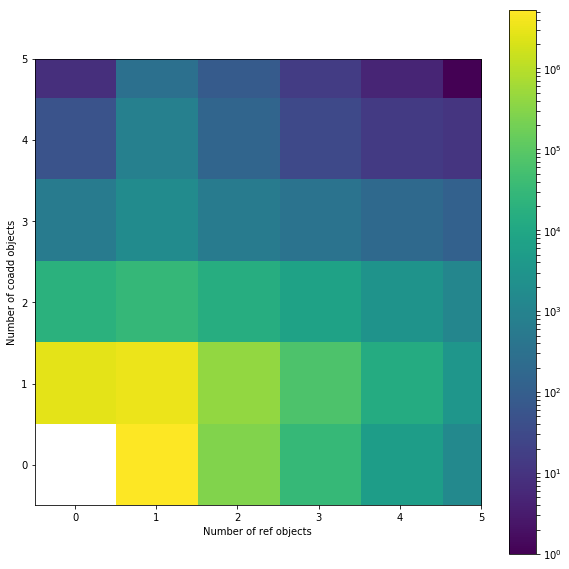

In [12]:
plt.figure(figsize=(10, 10))
e = (-0.5, n_max, -0.5, n_max)
plt.imshow(hist_2d, extent=e, origin='lower', norm=LogNorm())
plt.xlabel('Number of ref objects')
plt.ylabel('Number of coadd objects')
plt.axis([-0.5, 5, -0.5, 5])
cbar = plt.colorbar()
"""ax = plt.gca()
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')
t = cbar.ax.get_yticklabels();
labels = [item.get_text() for item in t]
cbar.ax.set_yticklabels(labels, color = 'white')"""
plt.savefig('matching_histogram.png', dpi = 300)

In [13]:
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_ref == 1) & (n_coadd == 1)))
zero_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_ref == 0) & (n_coadd == 1)))
ref_idx11 = results['row_index'][one_to_one_group_mask & ref_mask]
coadd_idx11 = results['row_index'][one_to_one_group_mask & coadd_mask]
ref_idx01 = results['row_index'][zero_to_one_group_mask & ref_mask]
coadd_idx01 = results['row_index'][zero_to_one_group_mask & coadd_mask]

In [14]:
ref_sc = SkyCoord(coordinatesRefCat['ra'][ref_idx11], coordinatesRefCat['dec'][ref_idx11], unit="deg")
coadd_sc = SkyCoord(coordinatesCoaddCat['ra'][coadd_idx11], coordinatesCoaddCat['dec'][coadd_idx11], unit="deg")
delta_ra = (coadd_sc.ra.arcsec - ref_sc.ra.arcsec)
delta_dec = (coadd_sc.dec.arcsec - ref_sc.dec.arcsec)
delta_arcsec = ref_sc.separation(coadd_sc).arcsec

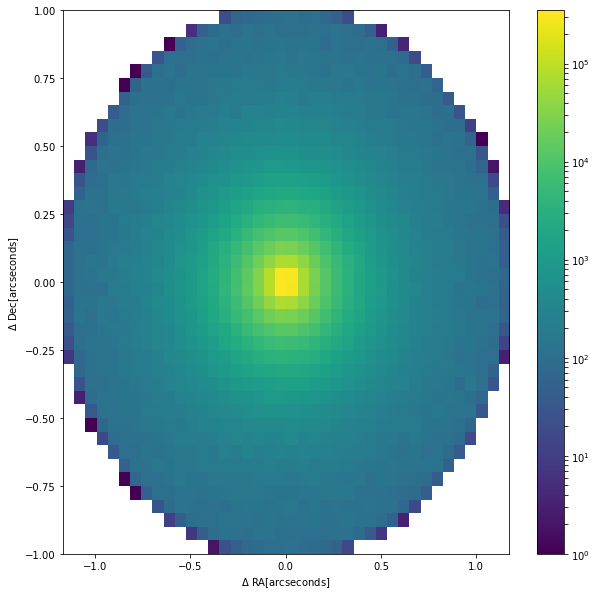

In [15]:
#hist, xedges, yedges = np.histogram2d(delta_ra, delta_dec, bins=50)
#plt.figure(figsize=(10, 10))
#extent = (xedges[0]*3600, xedges[-1]*3600, yedges[0]*3600, yedges[-1]*3600)
#plt.imshow(np.log10(hist))
#hist = np.histogram2d(delta_ra, delta_dec)
plt.figure(figsize=(10, 10))
plt.xlabel(r'$\Delta$ RA[arcseconds]')
plt.ylabel(r'$\Delta$ Dec[arcseconds]')
plt.hist2d(delta_ra, delta_dec, bins=40, norm=LogNorm());
cbar = plt.colorbar()
plt.savefig('deltaRA-DEC.png', dpi = 300)

In [16]:
lensing_filters = ['None',
              '@i_modelfit_CModel_flux',
              '@ext_shapeHSM_HsmShapeRegauss_resolution',
              '@ext_shapeHSM_HsmShapeRegauss_e1', 
              '@ext_shapeHSM_HsmShapeRegauss_e2',
              'detect_isPrimary',
              '~deblend_skipped',
              '~base_PixelFlags_flag_edge',
              '~base_PixelFlags_flag_interpolatedCenter',
              '~base_PixelFlags_flag_saturatedCenter',
              '~base_PixelFlags_flag_crCenter',
              '~base_PixelFlags_flag_bad',
              '~base_PixelFlags_flag_suspectCenter',
              '~base_PixelFlags_flag_clipped',
              '~ext_shapeHSM_HsmShapeRegauss_flag',
              'i_SN_cmodel >= 10',
              'HSM_res >= 0.3',
              'HSM_ell < 2.0',
              'ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4',
              'i_mag_cmodel < 24.5',
              'base_Blendedness_abs_flux < 0.42169650342',
              'All'
             ]

allFiltersList = []

def listParser(listOfFilters):
    rel_ops = set(['<', '<=', '>', '>='])
    operatorsTable = {'<' : operator.lt,
                      '>' : operator.gt,
                      '<=' : operator.le,
                      '>=' : operator.ge}
    values_list01 = []
    values_list11 = []
    AllA, AllB = None, None
    
    for x in listOfFilters:
        if x=='None':
            a=np.ones(len(coadd_idx01),dtype=bool)
            b=np.ones(len(coadd_idx11),dtype=bool)
        elif x=="All":
            a=AllA
            b=AllB
            AF_coadd_idx01 = coadd_idx01[np.where(a)]
            AF_coadd_idx11 = coadd_idx11[np.where(b)]
            NAF_coadd_idx01 = coadd_idx01[np.where(~a)]
            NAF_coadd_idx11 = coadd_idx11[np.where(~b)]
            AF_ref_idx11 = ref_idx11[np.where(b)]
            NAF_ref_idx11 = ref_idx11[np.where(~b)]
        elif not any(r in x for r in rel_ops):
            notNan=False
            logicalNot=False
            if x[0]=='@':
                notNan=True
                x=x[1:]
            elif x[0]=='~':
                logicalNot=True
                x=x[1:]
            a = coordinatesCoaddCat[x][coadd_idx01]
            b = coordinatesCoaddCat[x][coadd_idx11]
            if notNan:
                a=~np.isnan(a)
                b=~np.isnan(b)
            elif logicalNot:
                a=~a
                b=~b
        else:
            filterName,op,value=x.split(' ')
            value=np.float(value)
            a = operatorsTable[op](coordinatesCoaddCat[filterName][coadd_idx01], value)
            b = operatorsTable[op](coordinatesCoaddCat[filterName][coadd_idx11], value)
        values_list01.append(np.sum(a))
        values_list11.append(np.sum(b))
        if AllA is None:
            AllA=a
            AllB=b
        else:
            AllA = AllA & a
            AllB = AllB & b
    return np.array(values_list01), np.array(values_list11), AF_coadd_idx01, AF_coadd_idx11, NAF_coadd_idx01, NAF_coadd_idx11, AF_ref_idx11, NAF_ref_idx11

values_list01, values_list11, AF_coadd_idx01, AF_coadd_idx11, NAF_coadd_idx01, NAF_coadd_idx11, AF_ref_idx11, NAF_ref_idx11 = listParser(lensing_filters)

/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in greater_equal
/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:71: RuntimeWarning: invalid value encountered in greater_equal
/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in less
/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:71: RuntimeWarning: invalid value encountered in less
/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in less_equal
/global/homes/b/bhairav/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:71: RuntimeWarning: invalid value encountered in less_equal


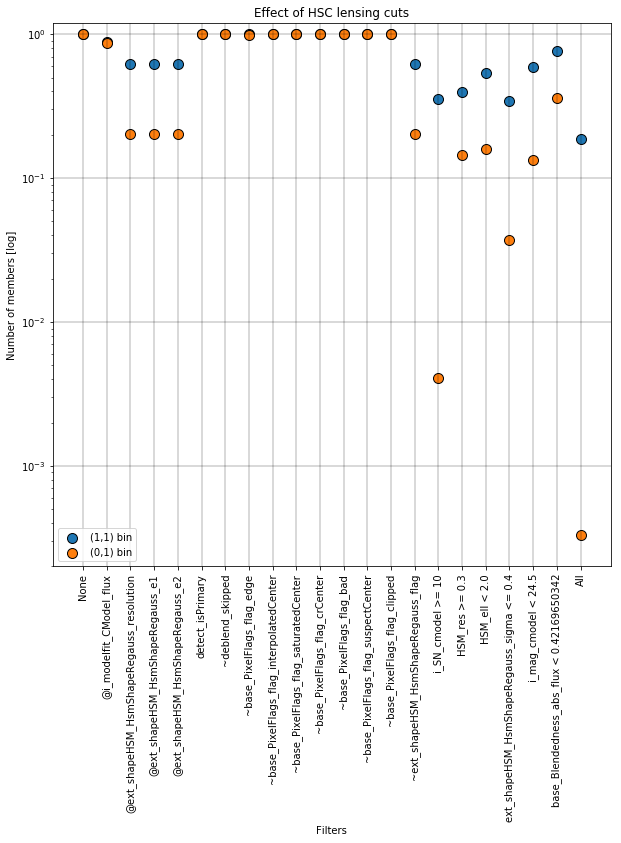

In [17]:
xaxis = list(range(len(lensing_filters)))
normedList01 = values_list01/values_list01.max()
normedList11 = values_list11/values_list11.max()
plt.figure(figsize=(10, 10))
plt.title('Effect of HSC lensing cuts')
plt.scatter(xaxis, normedList11, label='(1,1) bin', edgecolors='black', s=100)
plt.scatter(xaxis, normedList01, label='(0,1) bin', edgecolors='black', s=100)
plt.xticks(np.arange(len(values_list11)), lensing_filters, rotation=90)
plt.xlabel('Filters')
plt.ylabel('Number of members [log]')
ax = plt.gca()
ax.legend()
ax.set_yscale('log')
ax.grid(color='black', linestyle='-', linewidth=0.3)
plt.ylim(2e-4, 1.2)
plt.savefig('HSCLensingCuts', dpi = 300)

In [52]:
#Getting all accepted and unaccepted magnitudes for i_mag_cmodel:
accepted_i_mag_cmodel_01 = coordinatesCoaddCat['i_mag_cmodel'][AF_coadd_idx01]
naccepted_i_mag_cmodel_01 = coordinatesCoaddCat['i_mag_cmodel'][NAF_coadd_idx01]
accepted_i_mag_cmodel_11 = coordinatesCoaddCat['i_mag_cmodel'][AF_coadd_idx11]
naccepted_i_mag_cmodel_11 = coordinatesCoaddCat['i_mag_cmodel'][NAF_coadd_idx11]

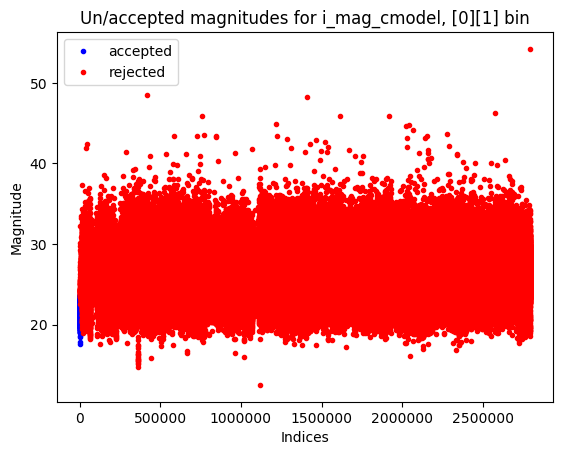

In [53]:
plt.plot(accepted_i_mag_cmodel_01,'b.',label='accepted')
plt.plot(naccepted_i_mag_cmodel_01,'r.',label='rejected')
plt.xlabel('Indices')
plt.ylabel('Magnitude')
plt.legend()
plt.title('Un/accepted magnitudes for i_mag_cmodel, [0][1] bin')

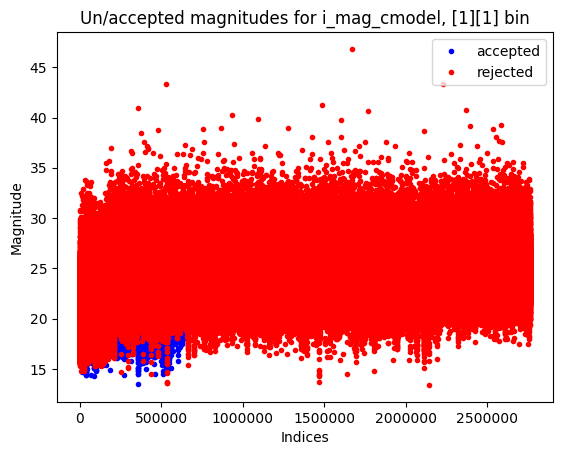

In [54]:
plt.plot(accepted_i_mag_cmodel_11,'b.',label='accepted')
plt.plot(naccepted_i_mag_cmodel_11,'r.',label='rejected')
plt.xlabel('Indices')
plt.ylabel('Magnitude')
plt.legend()
plt.title('Un/accepted magnitudes for i_mag_cmodel, [1][1] bin')

In [55]:
#Getting all accepted and unaccepted magnitudes for the i and u bands:

accepted_i_ref11 = coordinatesRefCat['mag_true_i'][AF_ref_idx11]
naccepted_i_ref11 = coordinatesRefCat['mag_true_i'][NAF_ref_idx11]
accepted_i_coadd11 = coordinatesCoaddCat['mag_i'][AF_coadd_idx11]
naccepted_i_coadd11 = coordinatesCoaddCat['mag_i'][NAF_coadd_idx11]

accepted_u_ref11 = coordinatesRefCat['mag_true_u'][AF_ref_idx11]
naccepted_u_ref11 = coordinatesRefCat['mag_true_u'][NAF_ref_idx11]
accepted_u_coadd11 = coordinatesCoaddCat['mag_u'][AF_coadd_idx11]
naccepted_u_coadd11 = coordinatesCoaddCat['mag_u'][NAF_coadd_idx11]

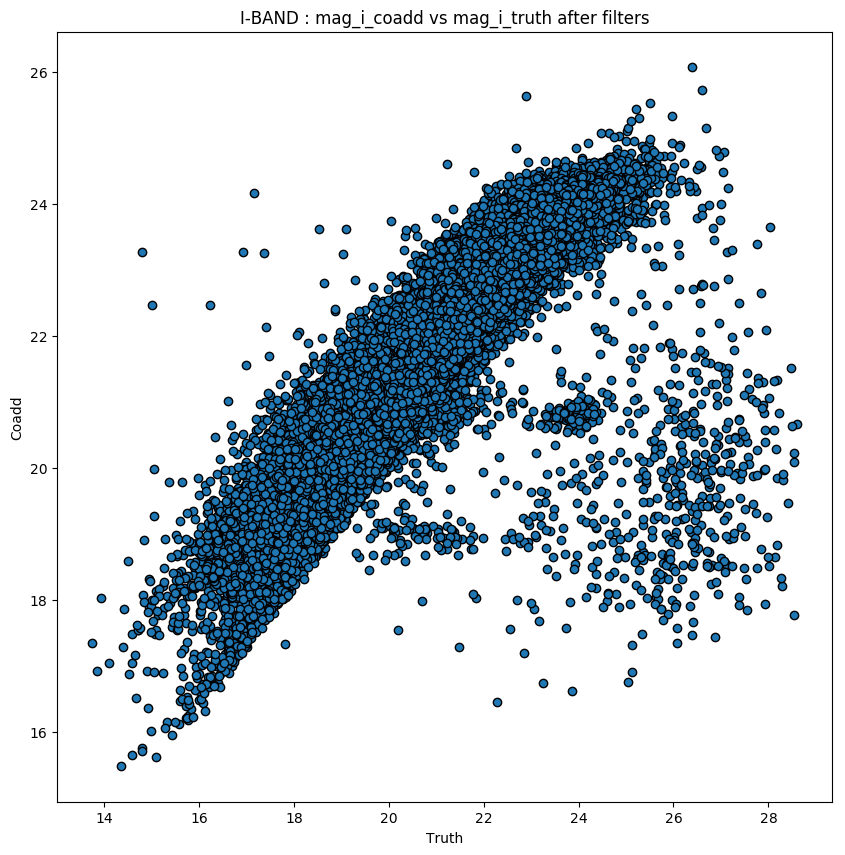

In [56]:
plt.figure(figsize=(10,10))
plt.scatter(accepted_i_ref11, accepted_i_coadd11, label='accepted', edgecolors='black')
plt.title('I-BAND : mag_i_coadd vs mag_i_truth after filters')
plt.xlabel('Truth')
plt.ylabel('Coadd')

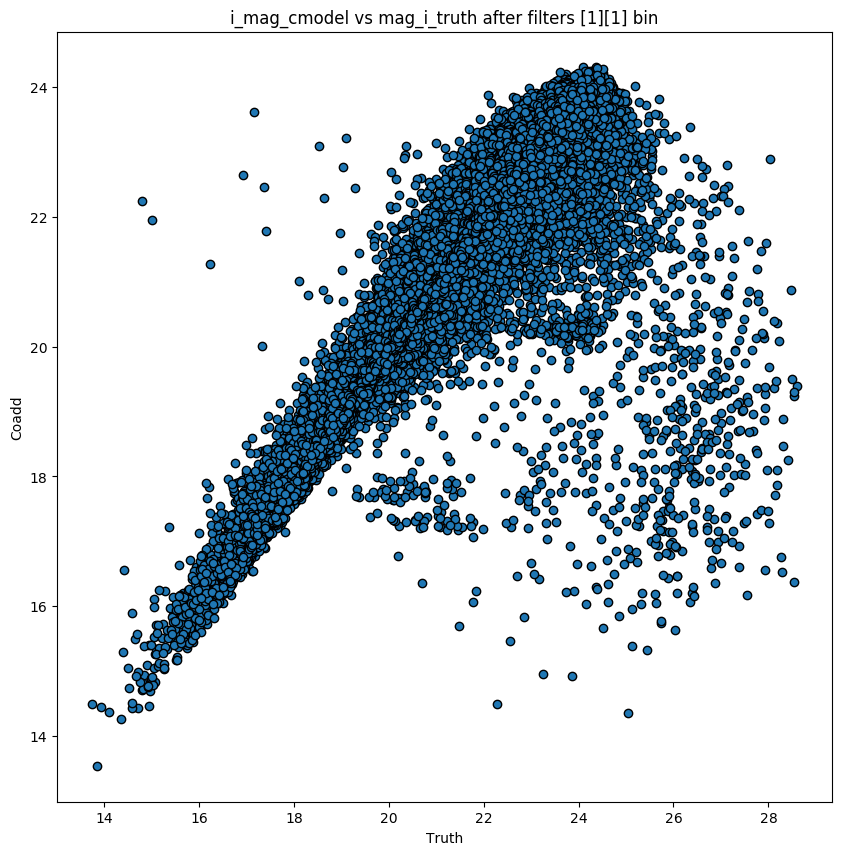

In [57]:
plt.figure(figsize=(10,10))
plt.scatter(accepted_i_ref11, accepted_i_mag_cmodel_11, label='accepted', edgecolors='black')
plt.title('i_mag_cmodel vs mag_i_truth after filters [1][1] bin')
plt.xlabel('Truth')
plt.ylabel('Coadd')

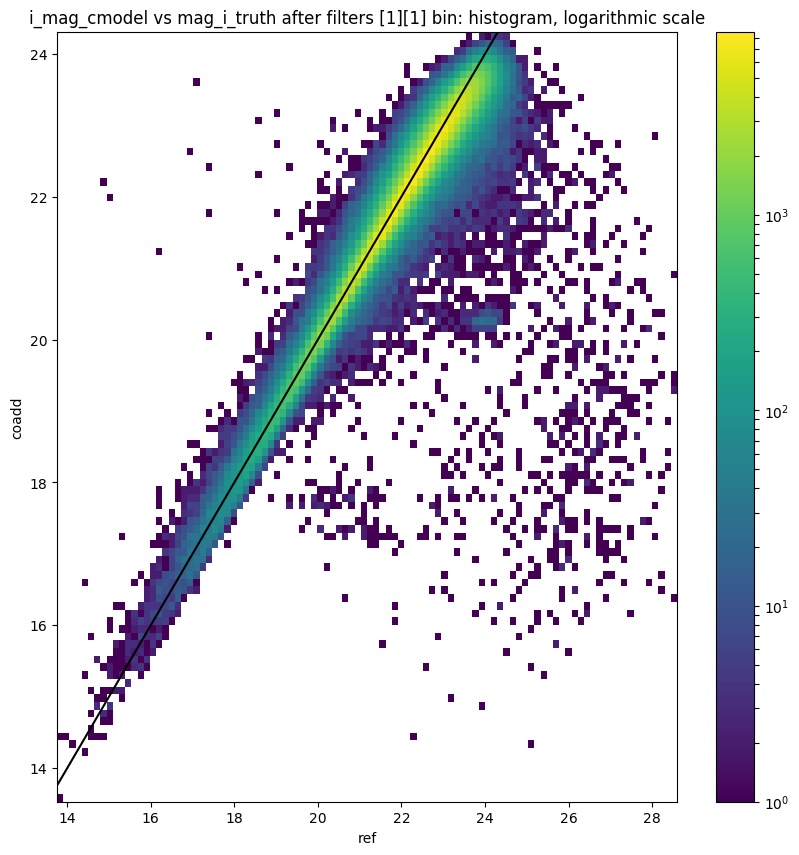

In [58]:
plt.figure(figsize=(10, 10))
plt.hist2d(accepted_i_ref11, accepted_i_mag_cmodel_11, bins=100, norm=LogNorm())
ax = plt.gca()
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, 'k-')
plt.colorbar()
plt.title('i_mag_cmodel vs mag_i_truth after filters [1][1] bin: histogram, logarithmic scale')
plt.xlabel('ref')
plt.ylabel('coadd')

925


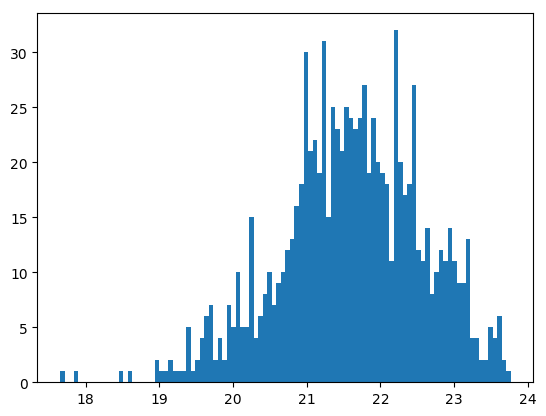

In [66]:
plt.hist(accepted_i_mag_cmodel_01, bins=100)
plt.style.use('default')
ra_accepted_i_mag_cmodel_01 = coordinatesCoaddCat['ra'][AF_coadd_idx01]
dec_accepted_i_mag_cmodel_01 = coordinatesCoaddCat['dec'][AF_coadd_idx01]

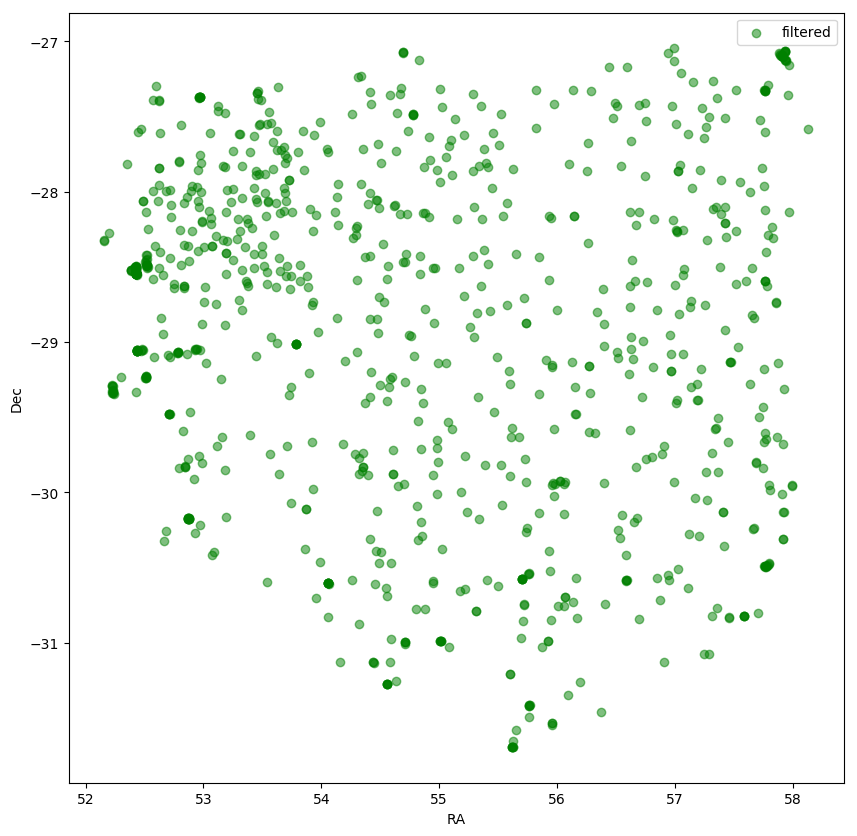

In [69]:
plt.figure(figsize=(10, 10))
#plt.scatter(coordinatesRefCat['ra'], coordinatesRefCat['dec'], color='red', label='ref', alpha=0.3)
#plt.scatter(coordinatesCoaddCat['ra'], coordinatesCoaddCat['dec'], color='blue', label='coadd', alpha=0.3)
plt.scatter(ra_accepted_i_mag_cmodel_01, dec_accepted_i_mag_cmodel_01, color='green', label='filtered', alpha=0.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend()

In [77]:
bright_objects_filtered_idx = []
for index in AF_coadd_idx01:
    if coordinatesCoaddCat['i_mag_cmodel'][index] < 19:
        bright_objects_filtered_idx.append(index)
bright_objects_filtered_ra = coordinatesCoaddCat['ra'][bright_objects_filtered_idx]
bright_objects_filtered_dec = coordinatesCoaddCat['dec'][bright_objects_filtered_idx]

6


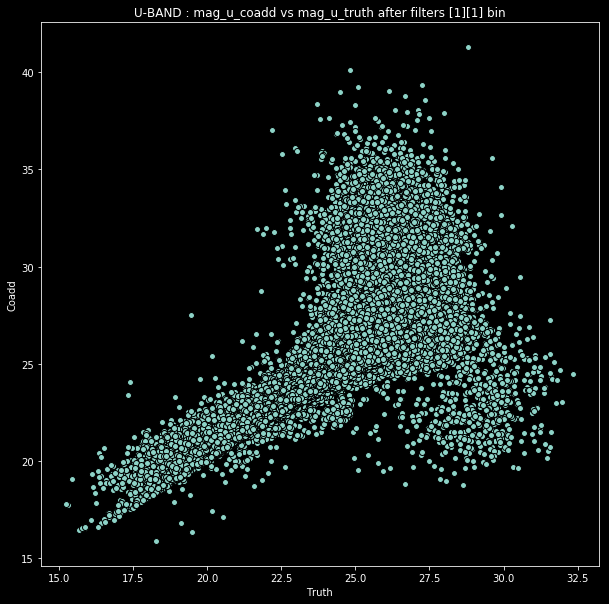

In [37]:
plt.figure(figsize=(10,10))
plt.scatter(accepted_u_ref11, accepted_u_coadd11, label='accepted', edgecolors='black')
plt.title('U-BAND : mag_u_coadd vs mag_u_truth after filters [1][1] bin')
plt.xlabel('Truth')
plt.ylabel('Coadd')

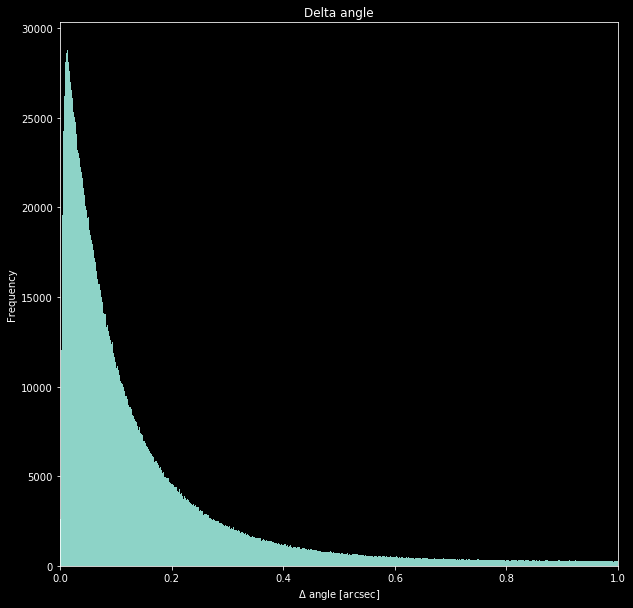

In [38]:
#Plotting Delta angle for the outputs
plt.figure(figsize=(10, 10))
values, edges, _ = plt.hist(delta_arcsec, bins=1000)
plt.xlim(0, 1.0)
plt.title('Delta angle')
plt.xlabel(r'$\Delta$ angle [arcsec]')
plt.ylabel('Frequency')
plt.savefig('DeltaAngle.png', dpi = 300)

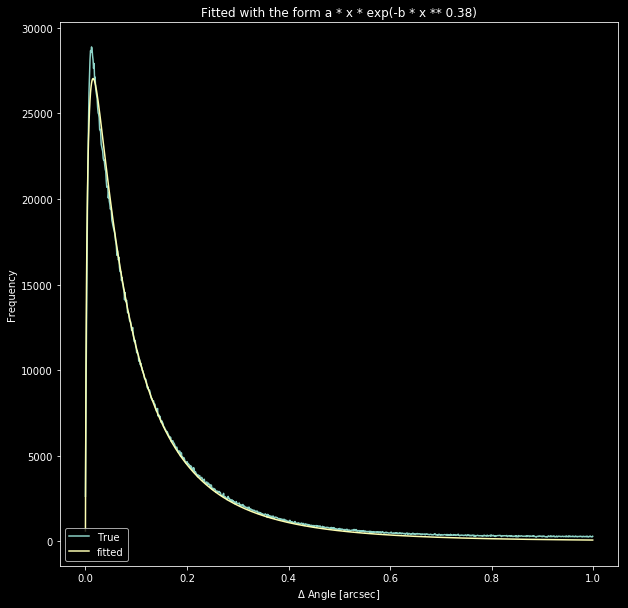

In [39]:
plt.figure(figsize = (10, 10))
plt.plot(edges[:-1], values, label='True')
x_data = edges[:-1]
y_data = values
plt.plot(edges[:-1], values*0., 'k:')
def fitfunction1(x, a, b):
    y = a * x * np.exp(-b * x ** 0.38)
    return y
(A, B), _ = curve_fit(fitfunction1, x_data, y_data)
plt.plot(x_data, fitfunction1(x_data, A, B), label='fitted')
plt.style.use("dark_background")
plt.title('Fitted with the form a * x * exp(-b * x ** 0.38)')
plt.xlabel('$\Delta$ Angle [arcsec]')
plt.ylabel('Frequency')
leg = plt.legend()
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=4000)
ax = plt.gca()
ax.legend(loc='lower left')
plt.savefig('functionFit2.png', dpi = 300)